In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

### download pre-trained weights

In [4]:
vgg_dir = './tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

VGG16 Parameters: 553MB [00:26, 20.8MB/s]                               


### download new training image data

Data image is from https://www.tensorflow.org/tutorials/image_retraining

In [5]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

Flowers Dataset: 229MB [00:03, 64.7MB/s]                              


### ConvNet Codes

we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.


In [6]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [7]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]
print(classes)

['dandelion', 'roses', 'daisy', 'tulips', 'sunflowers']


In [8]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

In [9]:
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
        
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/carnd/deep_learning_basics/Neural Networks/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting dandelion images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 imag

In [10]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

### Building the Classifier
Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [11]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [12]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


In [14]:
# classifier layers

inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [18]:
def get_batches(x, y, n_batches=100):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

In [19]:
epochs = 100
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/100 Iteration: 0 Training loss: 6.01679
Epoch: 1/100 Iteration: 1 Training loss: 24.73625
Epoch: 1/100 Iteration: 2 Training loss: 4.92540
Epoch: 1/100 Iteration: 3 Training loss: 8.34031
Epoch: 1/100 Iteration: 4 Training loss: 9.74318
Epoch: 0/100 Iteration: 5 Validation Acc: 0.6349
Epoch: 1/100 Iteration: 5 Training loss: 4.86423
Epoch: 1/100 Iteration: 6 Training loss: 4.34854
Epoch: 1/100 Iteration: 7 Training loss: 5.06744
Epoch: 1/100 Iteration: 8 Training loss: 2.95913
Epoch: 1/100 Iteration: 9 Training loss: 1.07724
Epoch: 0/100 Iteration: 10 Validation Acc: 0.6594
Epoch: 1/100 Iteration: 10 Training loss: 2.61710
Epoch: 1/100 Iteration: 11 Training loss: 3.90113
Epoch: 1/100 Iteration: 12 Training loss: 7.19497
Epoch: 1/100 Iteration: 13 Training loss: 2.36634
Epoch: 1/100 Iteration: 14 Training loss: 0.54536
Epoch: 0/100 Iteration: 15 Validation Acc: 0.7766
Epoch: 1/100 Iteration: 15 Training loss: 2.39459
Epoch: 1/100 Iteration: 16 Training loss: 1.43148
Epoch: 1/1

### Testing
Below you see the test accuracy. You can also see the predictions returned for images.

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.8828


In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

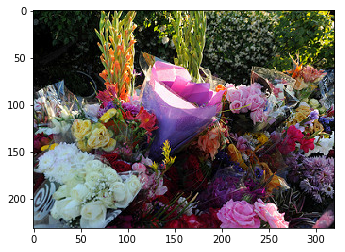

In [22]:
test_img_path = 'flower_photos/roses/10894627425_ec76bbc757_n.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [23]:
# Run this cell if you don't have a vgg graph built
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

/home/carnd/deep_learning_basics/Neural Networks/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [24]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


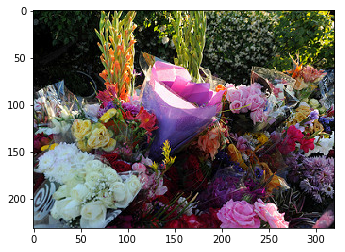

In [25]:
plt.imshow(test_img)

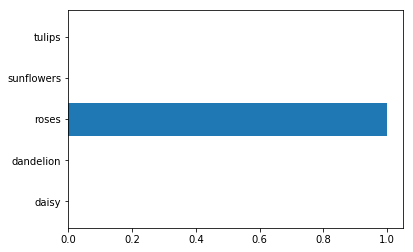

In [26]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)